In [27]:
%load_ext autoreload
%autoreload 2

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

from vehicle_eco_balance import Consumption, Car
from vehicle_eco_balance import get_interval_time, calc_acceleration, calc_distance, calc_gradient_angle, calc_efficiency

import numpy as np
from matplotlib import pyplot as plt

config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
# Download specific track from enviroCar using envirocar-py package
track_df = track_api.get_track('52b495a7e4b0f9afbd2e7fc6')
track_df.head()

,id,time,geometry,GPS Bearing.value,GPS Bearing.unit,GPS PDOP.value,GPS PDOP.unit,GPS VDOP.value,GPS VDOP.unit,GPS Accuracy.value,...,track.begin,track.end,track.touVersion,sensor.type,sensor.engineDisplacement,sensor.model,sensor.id,sensor.fuelType,sensor.constructionYear,sensor.manufacturer
0,52b495a7e4b0f9afbd2e7fc8,2013-12-20T16:24:35,POINT (7.60028 51.97748),13.570000,deg,1.3,precision,1.1,precision,5.0,...,2013-12-20T16:24:35Z,2013-12-20T17:38:02Z,2013-10-01,car,1149,Clio,525e30a9e4b000fe057e6c86,gasoline,2003,Renault
1,52b495a7e4b0f9afbd2e7fca,2013-12-20T16:24:41,POINT (7.60028 51.97748),13.570000,deg,1.3,precision,1.1,precision,5.0,...,2013-12-20T16:24:35Z,2013-12-20T17:38:02Z,2013-10-01,car,1149,Clio,525e30a9e4b000fe057e6c86,gasoline,2003,Renault
2,52b495a8e4b0f9afbd2e7fcc,2013-12-20T16:24:47,POINT (7.60024 51.97752),319.600006,deg,1.2,precision,1.0,precision,5.0,...,2013-12-20T16:24:35Z,2013-12-20T17:38:02Z,2013-10-01,car,1149,Clio,525e30a9e4b000fe057e6c86,gasoline,2003,Renault
3,52b495a8e4b0f9afbd2e7fce,2013-12-20T16:24:53,POINT (7.60007 51.97761),315.209991,deg,1.2,precision,1.0,precision,5.0,...,2013-12-20T16:24:35Z,2013-12-20T17:38:02Z,2013-10-01,car,1149,Clio,525e30a9e4b000fe057e6c86,gasoline,2003,Renault
4,52b495a8e4b0f9afbd2e7fd0,2013-12-20T16:24:59,POINT (7.59981 51.97773),267.910004,deg,1.2,precision,1.0,precision,5.0,...,2013-12-20T16:24:35Z,2013-12-20T17:38:02Z,2013-10-01,car,1149,Clio,525e30a9e4b000fe057e6c86,gasoline,2003,Renault


In [51]:
# Drop rows where specific columns are NaN
track_df.dropna(subset=['Speed.value', 'GPS Altitude.value'], inplace=True)

In [62]:
# Calculate interval times
dt = np.zeros(len(track_df['time']))

for i in range(1, len(track_df['time'])):
    dt[i] = get_interval_time(track_df['time'].iloc[i], track_df['time'].iloc[i-1])

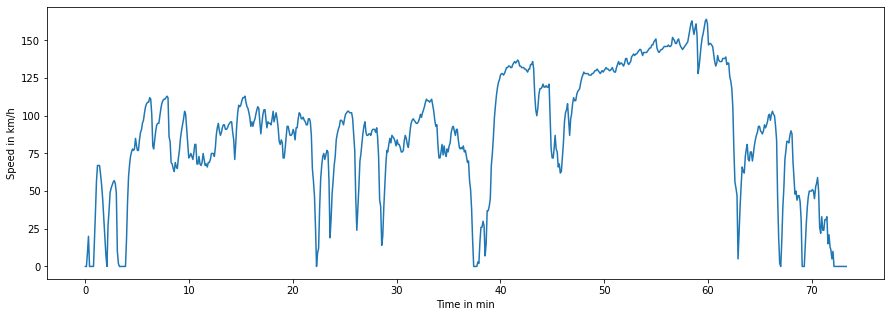

In [63]:
# Plot speed
speed = np.array(track_df['Speed.value'])
plt.figure(figsize=(15,5))
plt.xlabel('Time in min')
plt.ylabel('Speed in km/h')
plt.plot(dt.cumsum()/60, speed);

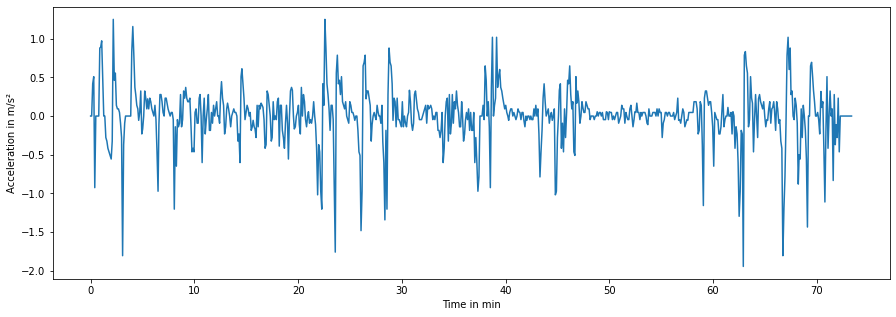

In [64]:
# Calculate and plot acceleration
acceleration = calc_acceleration(speed, dt)
plt.figure(figsize=(15,5))
plt.xlabel('Time in min')
plt.ylabel('Acceleration in m/s²')
plt.plot(dt.cumsum()/60, acceleration);

In [65]:
# Create list of points (latitude, longitude, altitude)
altitudes = np.array(track_df['GPS Altitude.value'])
geom = np.array(track_df['geometry'])

lngs = list(track_df['geometry'].x)
lats = list(track_df['geometry'].y)
points = [point for point in zip(lats, lngs, altitudes)]

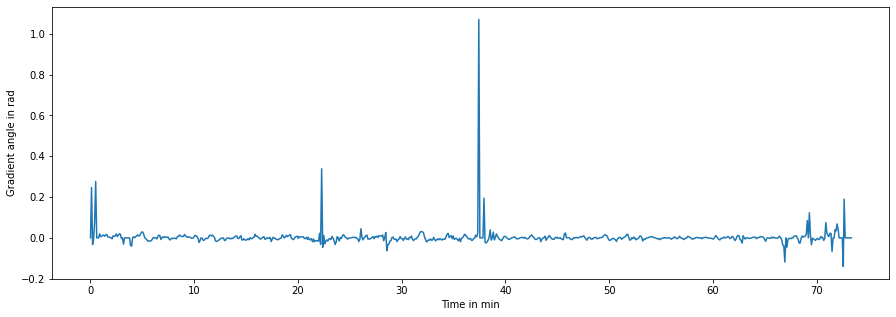

In [66]:
# Calculate and plot gradient angle
gradient_angle = np.zeros(len(points))

for i in range(1, len(points)):
    gradient_angle[i] = calc_gradient_angle(points[i-1],points[i])

plt.figure(figsize=(15,5))
plt.xlabel('Time in min')
plt.ylabel('Gradient angle in rad')
plt.plot(dt.cumsum()/60, gradient_angle);

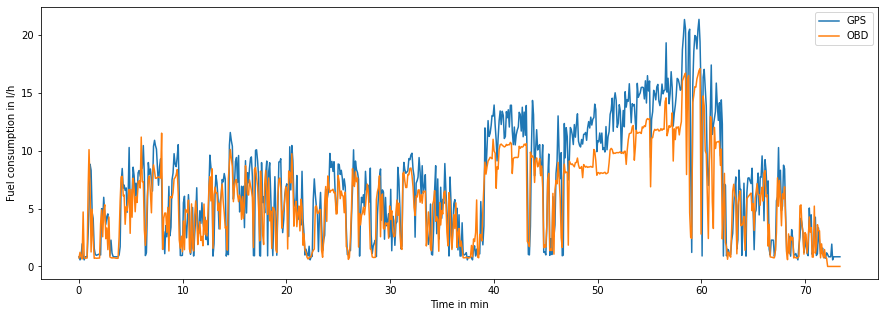

In [67]:
# Calculate and plot fuel consumption
cons = Consumption('fuel')
car = Car()

consumption_gps = cons.calculate_consumption(speed, acceleration, gradient_angle, car, 0.02)
consumption_obd = track_df['Consumption.value']

plt.figure(figsize=(15,5))
plt.plot(dt.cumsum()/60, consumption_gps, label="GPS");
plt.plot(dt.cumsum()/60, consumption_obd, label="OBD");
plt.xlabel('Time in min')
plt.ylabel('Fuel consumption in l/h')
plt.legend();

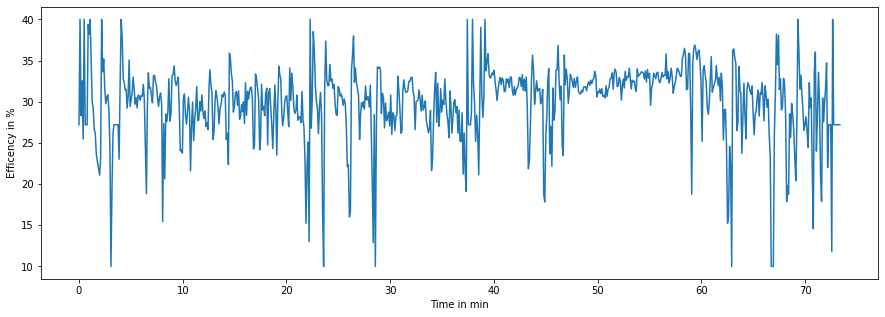

In [68]:
# Plot efficiency
plt.figure(figsize=(15,5))
plt.plot(dt.cumsum()/60, 100*cons.efficiency)
plt.xlabel('Time in min')
plt.ylabel('Efficency in %');

In [74]:
print('During this track a total of {:.2} litres gasoline have been consumed.'.format(cons.aggregate(dt)))

During this track a total of 8.7 litres gasoline have been consumed.


In [85]:
distance_total = np.sum(speed/3.6 * dt)/1000
print('During this track the average fuel consumption was {:.2} l per 100 km.'.format(cons.aggregate(dt)/distance_total*100))

During this track the average fuel consumption was 8.0 l per 100 km.
